# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

/home/jiin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_loader
from optim import Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [6]:
def preprocessing(eventID, normalize):
    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

    # define anomaly label
    labels = []
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == accident_sid]
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])
    
    return df_all_norm, label_df, H

In [7]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [8]:
def evaluate(label_all, score_all, adjust = False, plot=False, print_=False):
    true = label_all
    pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    auc = roc_auc_score(true, pred)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(accuracy_score(true, pred)))
        print('AUC score \t{:.4f}'.format(roc_auc_score(true, pred)))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(precision_score(true, pred, pos_label=1)))
        print('Recall   \t{:.4f}'.format(recall_score(true, pred, pos_label=1)))
        print('Macro F1 \t{:.4f}'.format(f1_score(true, pred, average='macro')))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, ap]

# Dataset Loading

In [9]:
target_sid = 1210005301 ## 1210005301  ## 1030001902

train_df = pd.read_csv('../data/{}/train_x.csv'.format(target_sid), index_col=0)
val_df = pd.read_csv('../data/{}/val_x.csv'.format(target_sid), index_col=0)
test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
train_df.columns = train_df.columns.astype(int)
val_df.columns = val_df.columns.astype(int)
test_df.columns = test_df.columns.astype(int)


train_label = pd.read_csv('../data/{}/train_y.csv'.format(target_sid), index_col=0)
val_label = pd.read_csv('../data/{}/val_y.csv'.format(target_sid), index_col=0)
test_label = pd.read_csv('../data/{}/test_y.csv'.format(target_sid), index_col=0)

H = nx.read_gpickle("../data/{}/sensor_graph.gpickle".format(target_sid))

## All Results

In [10]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [13]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

for normalize in ['standard']:
    # data
    args.dataset = 'Accident_{}'.format(normalize)
    args.normalize = normalize
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_loader(args, target_sid)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN_mean', 'GCN_rev_mean', 'GraphSAGE_mean', 'GraphSAGE_rev_mean', 'STGCN_mean', 'STGCN_rev_mean'], ['GCN_gc', 'GCN_gc', 'GraphSAGE_gc', 'GraphSAGE_gc', 'STGCN','STGCN']):
            args.module=module
            args.nu = nu
            train_mode = 'all' # all. select
            self_loop = '_sl'
            args.pooling = 'mean'
            # args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
            args.exp_name = f'{args.normalize}_{name}_{args.nu}{self_loop}_5301'


            checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
            # checkpoints_path=f'./checkpoints/{args.exp_name}+epoch1.pt'
        #     logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
        #     logger=logging.getLogger('OCGNN')
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center']
            radius = torch.load(checkpoints_path)['radius']

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, acc, auc, far, pre, rec, macro_f1, ap])
            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, acc, auc, far, pre, rec, macro_f1, ap])

train dataset


100%|██████████| 25870/25870 [00:33<00:00, 770.97it/s] 


val dataset


100%|██████████| 8904/8904 [00:10<00:00, 875.12it/s] 


test dataset


100%|██████████| 8904/8904 [00:12<00:00, 715.15it/s] 


402 140 140
##############################
./checkpoints/standard_GCN_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:02, 63.82it/s] 


tensor(0.0919, device='cuda:0', dtype=torch.float64) 0.11382960505783554


140it [00:00, 231.22it/s]


##############################
./checkpoints/standard_GCN_rev_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 208.47it/s]


tensor(0.0131, device='cuda:0', dtype=torch.float64) 0.012127488851547236


140it [00:00, 205.41it/s]


##############################
./checkpoints/standard_GraphSAGE_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 185.83it/s]


tensor(0.0026, device='cuda:0', dtype=torch.float64) 0.0014224985742475825


140it [00:00, 232.06it/s]


##############################
./checkpoints/standard_GraphSAGE_rev_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 179.94it/s]


tensor(0.0363, device='cuda:0', dtype=torch.float64) 0.0455133072659373


140it [00:00, 163.84it/s]


##############################
./checkpoints/standard_STGCN_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:12, 11.48it/s]


tensor(0.0005, device='cuda:0', dtype=torch.float64) 0.0001843757738242857


140it [00:12, 11.52it/s]


##############################
./checkpoints/standard_STGCN_rev_mean_0.01_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:10, 12.94it/s]


tensor(0.0003, device='cuda:0', dtype=torch.float64) 0.0005087104404810816


140it [00:09, 14.12it/s]


##############################
./checkpoints/standard_GCN_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 190.75it/s]


tensor(0.0283, device='cuda:0', dtype=torch.float64) 0.04818624034523964


140it [00:00, 145.29it/s]


##############################
./checkpoints/standard_GCN_rev_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:01, 139.86it/s]


tensor(0.0677, device='cuda:0', dtype=torch.float64) 0.06366890370845796


140it [00:00, 142.99it/s]


##############################
./checkpoints/standard_GraphSAGE_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 143.63it/s]


tensor(0.0405, device='cuda:0', dtype=torch.float64) 0.03371657114475966


140it [00:01, 123.38it/s]


##############################
./checkpoints/standard_GraphSAGE_rev_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:01, 123.65it/s]


tensor(0.0255, device='cuda:0', dtype=torch.float64) 0.025349629390984774


140it [00:01, 121.36it/s]


##############################
./checkpoints/standard_STGCN_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:09, 14.35it/s]


tensor(0.0004, device='cuda:0', dtype=torch.float64) 0.0003010108310263604


140it [00:08, 17.21it/s]


##############################
./checkpoints/standard_STGCN_rev_mean_0.05_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:08, 16.19it/s]


tensor(0.0050, device='cuda:0', dtype=torch.float64) 27.068035125732422


140it [00:05, 24.32it/s]


##############################
./checkpoints/standard_GCN_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 248.03it/s]


tensor(0.0005, device='cuda:0', dtype=torch.float64) 0.0009504667075816541


140it [00:00, 243.43it/s]


##############################
./checkpoints/standard_GCN_rev_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:01, 131.07it/s]


tensor(0.0740, device='cuda:0', dtype=torch.float64) 0.06564917340874672


140it [00:00, 147.10it/s]


##############################
./checkpoints/standard_GraphSAGE_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 192.31it/s]


tensor(0.0249, device='cuda:0', dtype=torch.float64) 0.02289676833897829


140it [00:00, 173.31it/s]


##############################
./checkpoints/standard_GraphSAGE_rev_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 150.85it/s]


tensor(0.0295, device='cuda:0', dtype=torch.float64) 0.020816741324961183


140it [00:00, 180.48it/s]


##############################
./checkpoints/standard_STGCN_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:09, 14.19it/s]


tensor(0.0002, device='cuda:0', dtype=torch.float64) 0.00016267565806629136


140it [00:13, 10.65it/s]


##############################
./checkpoints/standard_STGCN_rev_mean_0.1_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:10, 12.97it/s]


tensor(0.0132, device='cuda:0', dtype=torch.float64) 27.068496704101562


140it [00:11, 12.14it/s]


##############################
./checkpoints/standard_GCN_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 249.21it/s]


tensor(0.0014, device='cuda:0', dtype=torch.float64) 0.0007342987810261548


140it [00:00, 189.70it/s]


##############################
./checkpoints/standard_GCN_rev_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 141.40it/s]


tensor(0.0007, device='cuda:0', dtype=torch.float64) 0.005094852857291698


140it [00:00, 157.44it/s]


##############################
./checkpoints/standard_GraphSAGE_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 164.58it/s]


tensor(0.0174, device='cuda:0', dtype=torch.float64) 0.01326877642422915


140it [00:00, 169.09it/s]


##############################
./checkpoints/standard_GraphSAGE_rev_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 191.75it/s]


tensor(0.0211, device='cuda:0', dtype=torch.float64) 0.019281911104917525


140it [00:00, 187.53it/s]


##############################
./checkpoints/standard_STGCN_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:12, 10.86it/s]


tensor(0.0004, device='cuda:0', dtype=torch.float64) 0.00038309189258143304


140it [00:11, 11.77it/s]


##############################
./checkpoints/standard_STGCN_rev_mean_0.2_sl_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:11, 12.19it/s]


tensor(0.0098, device='cuda:0', dtype=torch.float64) 27.068368911743164


140it [00:11, 11.97it/s]


In [14]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'AUC', 'far', 'precision', 'recall', 'F1_score', 'AP'])
result_all


,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
0,GCN_mean,standard,0.01,False,0.961590,0.501030,0.963855,0.036145,0.011321,0.498827,0.029834
1,GCN_mean,standard,0.01,True,0.963724,0.536879,0.784314,0.215686,0.083019,0.550686,0.045197
2,GCN_rev_mean,standard,0.01,False,0.962601,0.505209,0.935897,0.064103,0.018868,0.505044,0.030410
3,GCN_rev_mean,standard,0.01,True,0.964510,0.537284,0.768421,0.231579,0.083019,0.552056,0.046517
4,GraphSAGE_mean,standard,0.01,False,0.961815,0.495659,1.000000,0.000000,0.000000,0.490268,0.029762
5,GraphSAGE_mean,standard,0.01,True,0.961815,0.495659,1.000000,0.000000,0.000000,0.490268,0.029762
6,GraphSAGE_rev_mean,standard,0.01,False,0.962376,0.495949,1.000000,0.000000,0.000000,0.490414,0.029762
7,GraphSAGE_rev_mean,standard,0.01,True,0.962376,0.495949,1.000000,0.000000,0.000000,0.490414,0.029762
8,STGCN_mean,standard,0.01,False,0.959569,0.494502,1.000000,0.000000,0.000000,0.489684,0.029762
9,STGCN_mean,standard,0.01,True,0.959569,0.494502,1.000000,0.000000,0.000000,0.489684,0.029762


In [15]:
result_all[(result_all.adjust==True)]

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
1,GCN_mean,standard,0.01,True,0.963724,0.536879,0.784314,0.215686,0.083019,0.550686,0.045197
3,GCN_rev_mean,standard,0.01,True,0.964510,0.537284,0.768421,0.231579,0.083019,0.552056,0.046517
5,GraphSAGE_mean,standard,0.01,True,0.961815,0.495659,1.000000,0.000000,0.000000,0.490268,0.029762
7,GraphSAGE_rev_mean,standard,0.01,True,0.962376,0.495949,1.000000,0.000000,0.000000,0.490414,0.029762
9,STGCN_mean,standard,0.01,True,0.959569,0.494502,1.000000,0.000000,0.000000,0.489684,0.029762
11,STGCN_rev_mean,standard,0.01,True,0.978661,0.736613,0.290503,0.709497,0.479245,0.780565,0.355522
13,GCN_mean,standard,0.05,True,0.936321,0.648952,0.811983,0.188017,0.343396,0.604877,0.084106
15,GCN_rev_mean,standard,0.05,True,0.949124,0.823811,0.669675,0.330325,0.690566,0.710111,0.237321
17,GraphSAGE_mean,standard,0.05,True,0.929358,0.519169,0.946078,0.053922,0.083019,0.514335,0.031768
19,GraphSAGE_rev_mean,standard,0.05,True,0.935310,0.648432,0.815416,0.184584,0.343396,0.603161,0.082927


In [14]:
result_all.to_csv('result/OCGNN_meanpool_selfloop_acc5301_labelv2.csv')

## Case Result

In [54]:
args.dataset = 'Accident_standard'
# args.module = 'GraphSAGE_gc'
# args.module = 'GCN_gc'
args.module = 'STGCN'
name = 'STGCN_mean'
args.normalize = 'standard'
args.nu = 0.05
args.pooling = 'mean'
args.reverse = False
train_mode = 'all'
self_loop = '_sl'
# args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
args.exp_name = f'{args.normalize}_{name}_{args.nu}{self_loop}_5301'


In [55]:
checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints/standard_STGCN_mean_0.05_sl_5301+bestcheckpoint.pt'

In [56]:
args.normalize

'standard'

In [57]:
    target_sid = 1210005301 ## 1210005301 ## 1030001902
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    # args.normalize = normalize
    
    # df_all_norm, label_df, H = preprocessing(eventID, args.normalize)

In [53]:
# train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
# len(train_loader), len(val_loader), len(test_loader)

train_loader, val_loader, test_loader = traffic_loader(args, target_sid)
len(train_loader), len(val_loader), len(test_loader)

train dataset


100%|██████████| 25870/25870 [00:25<00:00, 1005.20it/s]


val dataset


100%|██████████| 8904/8904 [00:09<00:00, 949.06it/s] 


test dataset


100%|██████████| 8904/8904 [00:08<00:00, 1042.16it/s]


(402, 140, 140)

In [58]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 658


In [59]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path)['model'])
model.eval()
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']
model, data_center, radius

./checkpoints/standard_STGCN_mean_0.05_sl_5301+bestcheckpoint.pt


(STGCN(
   (stblocks): ModuleList(
     (0): STblock(
       (tmp_conv1): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(1, 4, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (graph_conv): GCNConv(2, 4)
       (tmp_conv2): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(4, 16, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (relu): ReLU()
       (dropout): Dropout(p=0.25, inplace=False)
     )
     (1): STblock(
       (tmp_conv1): TemporalCon

In [60]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

2it [00:00, 13.96it/s]

tensor([0.0928, 0.0928], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.0928, 0.0928], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.0928, 0.0928], device='cuda:0', grad_fn=<SliceBackward0>)


6it [00:00, 11.37it/s]

tensor([0.0928, 0.0928], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.0928, 0.0928], device='cuda:0', grad_fn=<SliceBackward0>)


140it [00:06, 21.00it/s]

[9.0045297e-08 9.0085315e-08 9.0122555e-08 9.0077002e-08 9.0059224e-08]


0.0003010103275300935

In [61]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

140it [00:06, 21.64it/s]


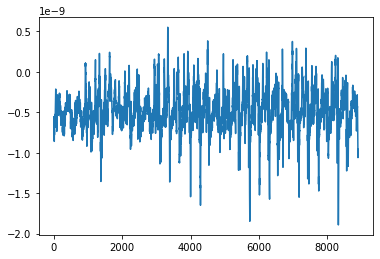

In [62]:
plt.plot(score_all)

Accuracy 	0.9334
AUC score 	0.5523
FAR score 	0.9039
Precision 	0.0961
Recall   	0.1472
Macro F1 	0.5408
Avg Precision 	0.0395
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8639
           1       0.10      0.15      0.12       265

    accuracy                           0.93      8904
   macro avg       0.53      0.55      0.54      8904
weighted avg       0.95      0.93      0.94      8904



[0.9334007187780773,
 0.5523440212987615,
 0.9039408866995073,
 0.0960591133004926,
 0.1471698113207547,
 0.5408204609003953,
 0.039518852433621465]

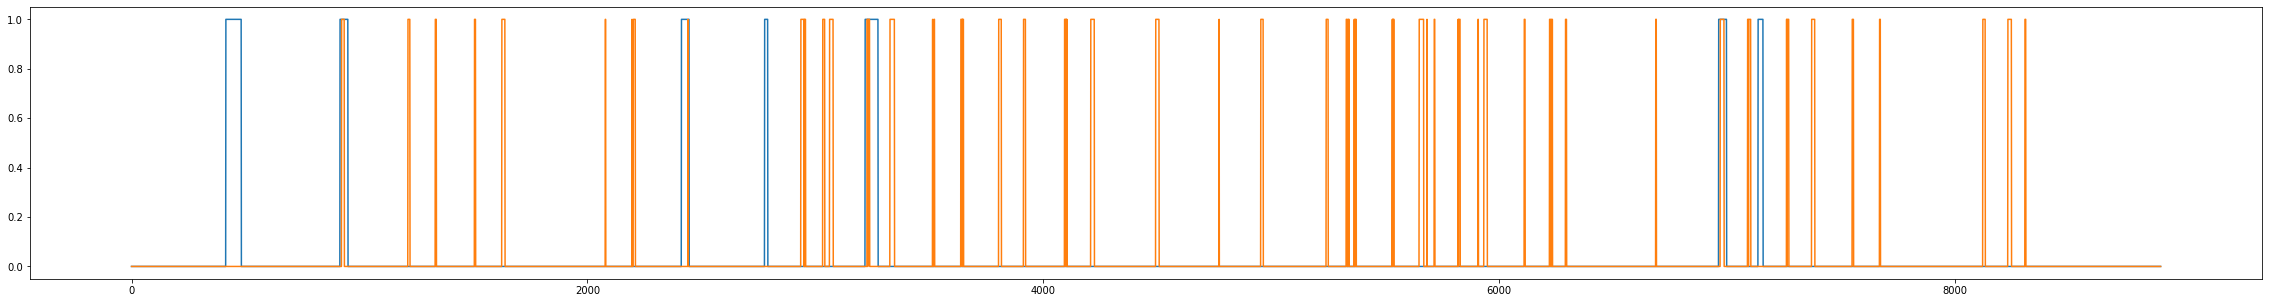

In [63]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9471
AUC score 	0.7825
FAR score 	0.6951
Precision 	0.3049
Recall   	0.6075
Macro F1 	0.6892
Avg Precision 	0.1969
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8639
           1       0.30      0.61      0.41       265

    accuracy                           0.95      8904
   macro avg       0.65      0.78      0.69      8904
weighted avg       0.97      0.95      0.96      8904



[0.9471024258760108,
 0.7825327005440446,
 0.6950757575757576,
 0.30492424242424243,
 0.6075471698113207,
 0.6891857529462728,
 0.19693600424732502]

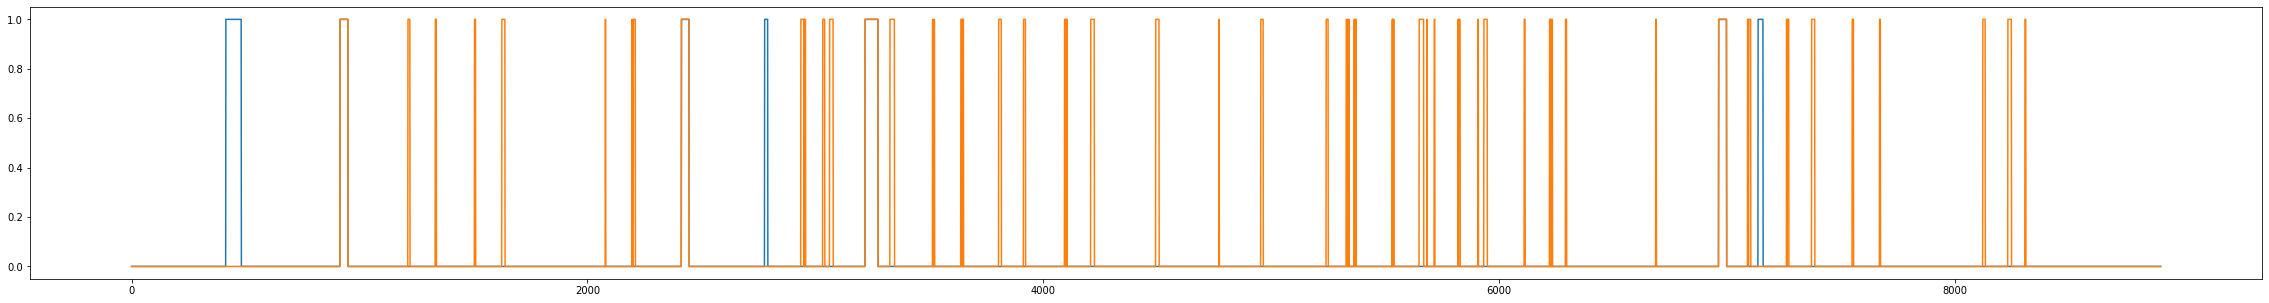

In [64]:
evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

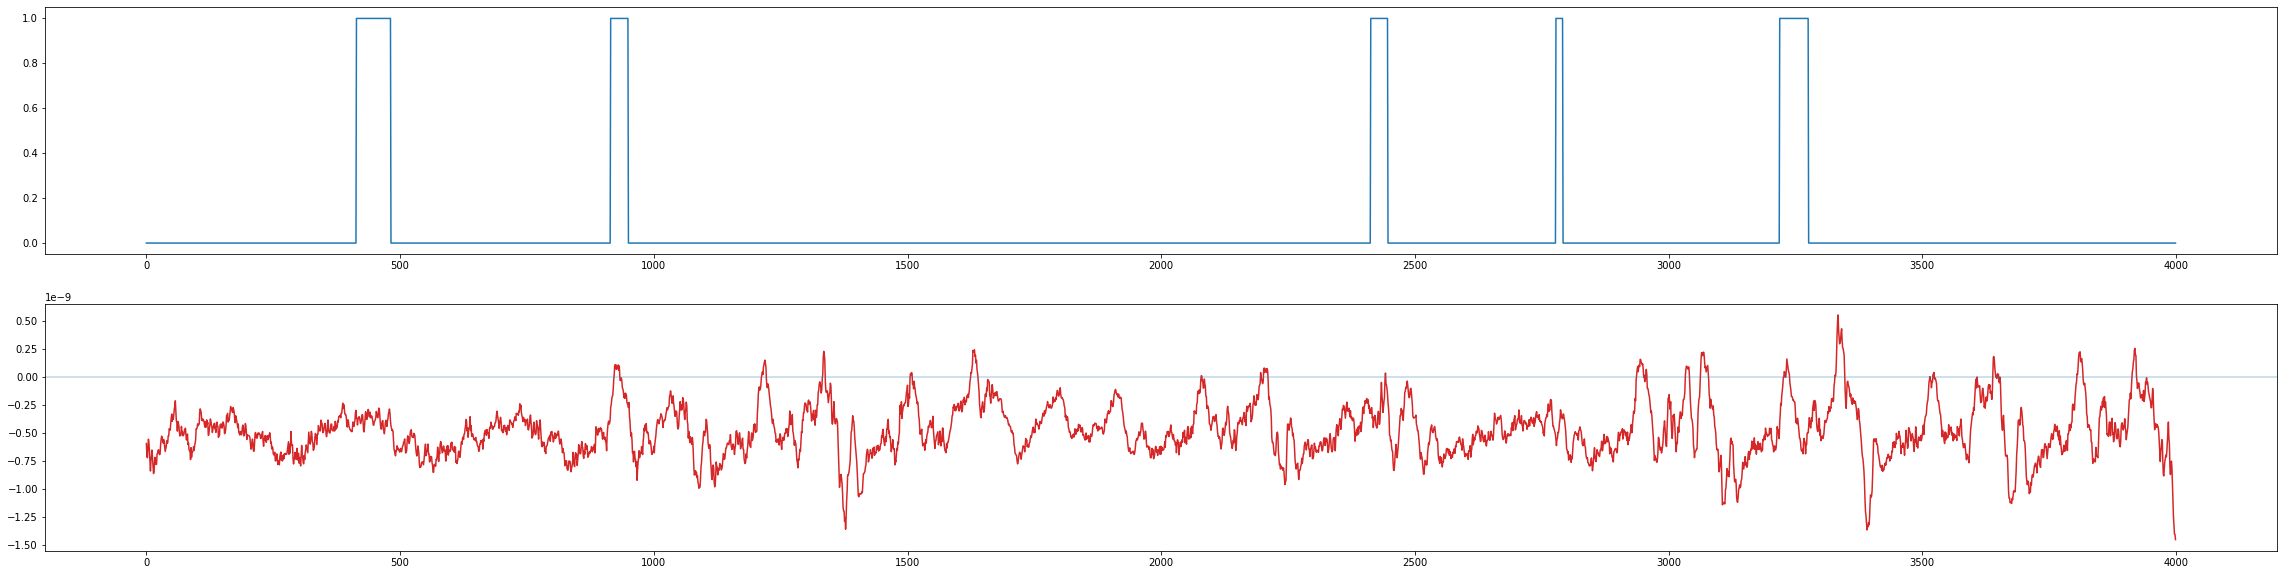

In [65]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


In [29]:
# def Cumulative(lists, window=12):
#     cu_list = []
#     length = len(lists)
#     cu_list = [(lists[x-window:x].mean()) for x in range(window, length)]
#     return cu_list + [0]*window

# # plt.plot(Cumulative(score_all, window=2))
# cum_score_all = Cumulative(score_all, window=)
# evaluate(label_all, cum_score_all, adjust=True, plot=False, print_=True)

## Case prediction plot

In [35]:
tmp = np.argsort(dist_all)[::-1][:100]
tmp = np.random.choice(tmp, 10)
tmp

array([3336, 1676, 1656, 4212, 3944, 6224, 7384, 5666, 1658, 4218])

In [36]:
len(dist_all)

8904

In [37]:
with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

# test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]
# test_df = test_df.rolling(window=3).mean()

In [38]:
test_df.index = pd.to_datetime(test_df.index)

In [39]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

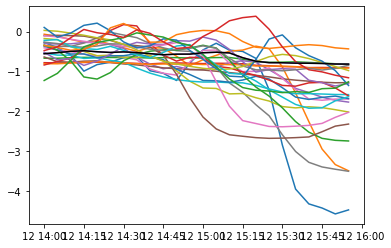

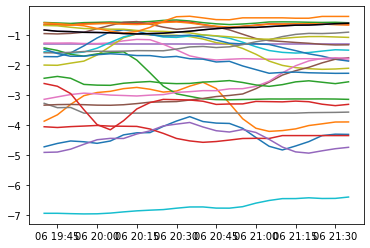

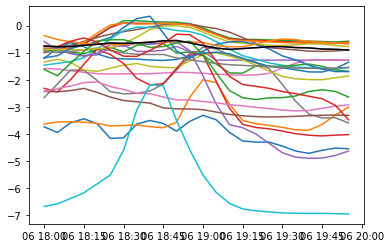

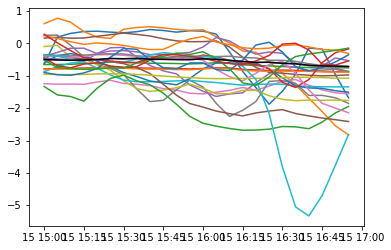

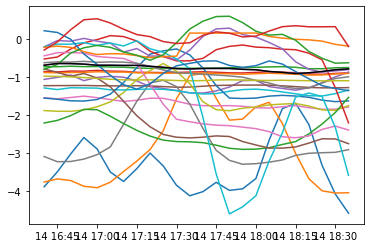

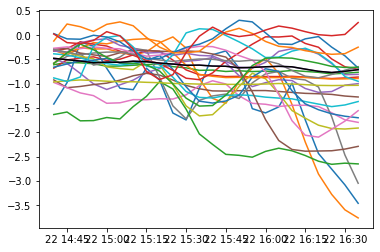

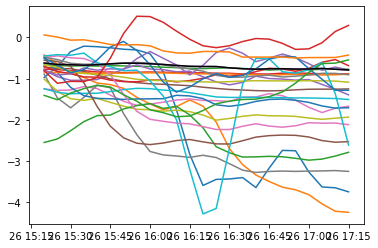

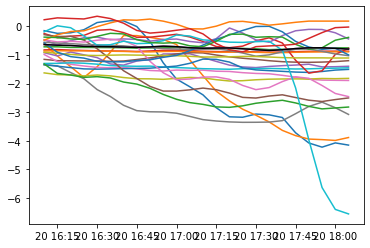

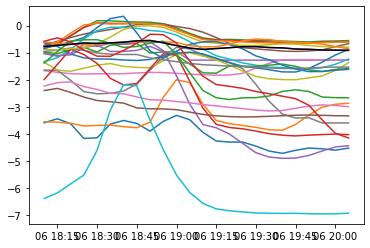

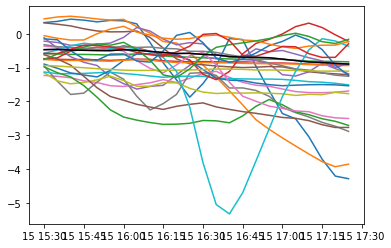

In [40]:
for i in tmp:
    plt.figure()
    plt.plot(test_df[i:i+24])
    plt.plot(test_df[i:i+24][target_sid], color='k')
    plt.show()

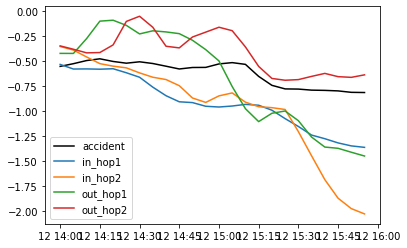

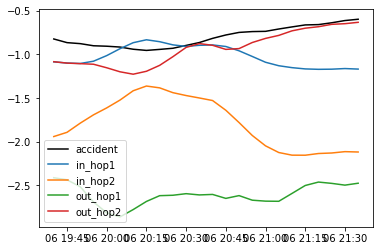

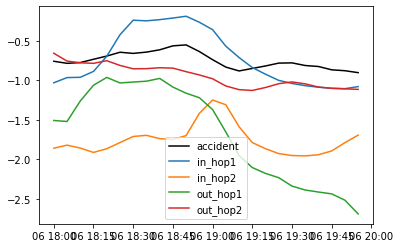

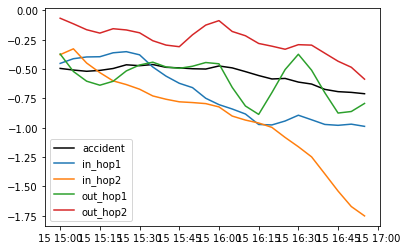

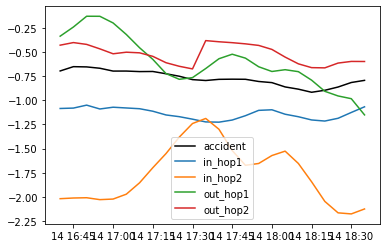

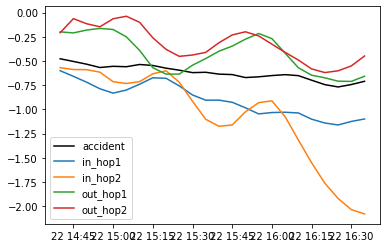

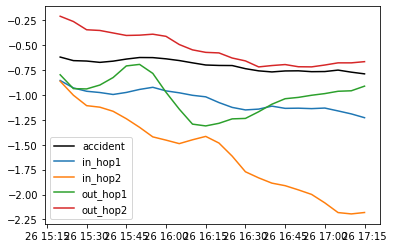

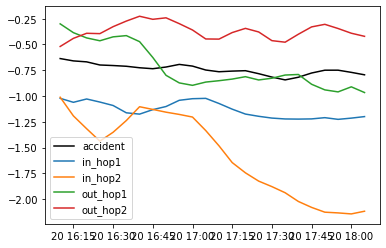

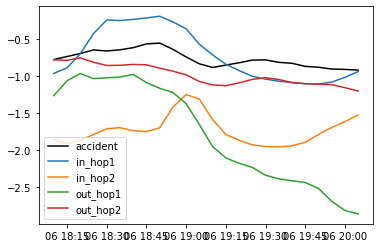

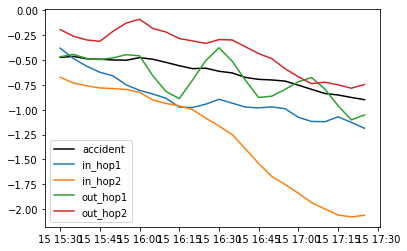

In [41]:
for i in tmp:
    plt.figure()
    plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
    plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
    plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
    plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
    plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
    plt.legend()
    plt.show()
    

### Prediction Case for true incident

Not detected
Detected
MTTD =  [14]


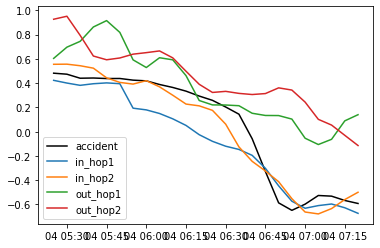

Not detected
Not detected
Detected
MTTD =  [13]


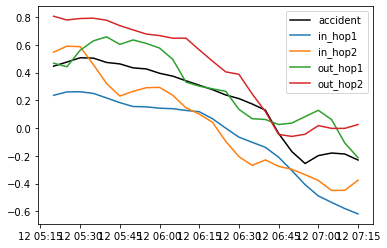

Detected
MTTD =  [10]


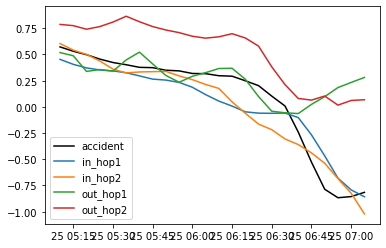

Detected
MTTD =  [18]


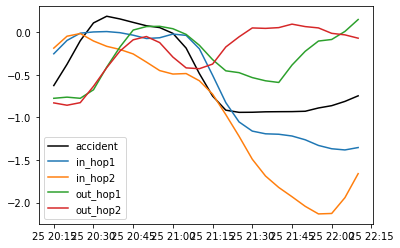

In [91]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
    

In [92]:
accident_case

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
45,3735057,2020-11-22 20:24:00,2020-11-22 20:21:00,2020-11-22 20:41:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차끼리 추돌사고로 정체,[1210005301],127.006911,37.515645,1210005301
136,3736508,2020-11-24 07:20:00,2020-11-24 07:19:00,2020-11-24 07:39:00,NaN,NaN,tbs 교통방송,ACCIDENT,"올림픽대로 공항방면 (한남대교 → 반포대교) 3,4차로 승용차,화물차 추돌사고 처리...",[1210005301],127.006436,37.515302,1210005301
147,3736513,2020-11-24 07:26:19,2020-11-24 07:20:00,2020-11-24 07:50:00,NaN,NaN,경찰청(UTIC),ACCIDENT,"[사고] 올림픽대로 한남대교 에서 반포대교 방향 3,4차로 교통사고 주의운전",[1210005301],127.007420,37.516077,1210005301
20,3741845,2020-11-29 11:47:24,2020-11-29 11:45:00,2020-11-29 12:15:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 올림픽대로 한남대교 에서 반포대교 방향 2차로 교통사고,[1210005301],127.011501,37.519593,1210005301
91,3748667,2020-12-06 19:31:00,2020-12-06 19:29:00,2020-12-06 19:49:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.005848,37.514726,1210005301
104,3751949,2020-12-10 06:57:00,2020-12-10 06:55:00,2020-12-10 07:15:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.005418,37.514365,1210005301
91,3756142,2020-12-15 07:10:00,2020-12-15 07:07:00,2020-12-15 07:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 (하남 → 공항) 반포대교 조금 못 간 지점 2차로 승용차관련 추돌사고 ...,[1210005301],127.003518,37.512955,1210005301
175,3760761,2020-12-21 06:55:00,2020-12-21 06:53:00,2020-12-21 07:13:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 1차로 추돌사고로 정체,[1210005301],127.006934,37.515717,1210005301
25,3762631,2020-12-23 07:54:00,2020-12-23 07:50:00,2020-12-23 08:10:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 3차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.006594,37.515446,1210005301
139,3769104,2021-01-02 14:10:00,2021-01-02 14:07:00,2021-01-02 14:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 추돌사고 처리작업으로 정체,[1210005301],127.006685,37.515446,1210005301


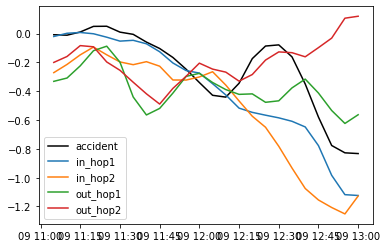

2437 0


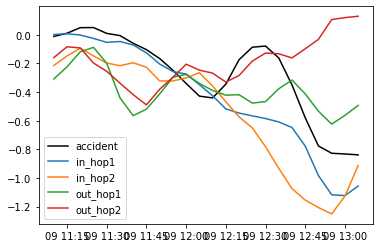

2438 0


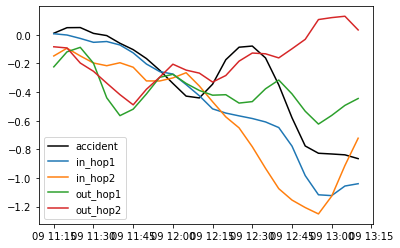

2439 0


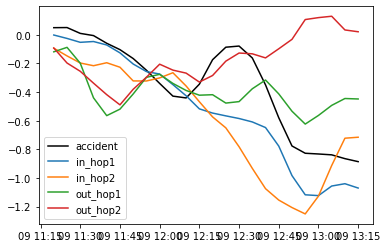

2440 0


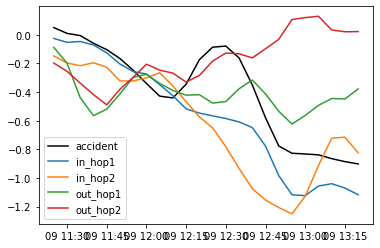

2441 0


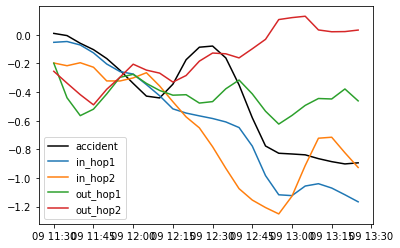

2442 0


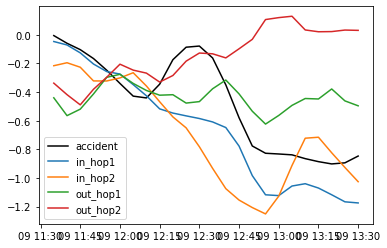

2443 0


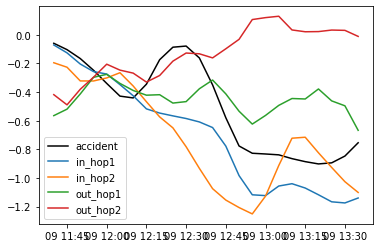

2444 0


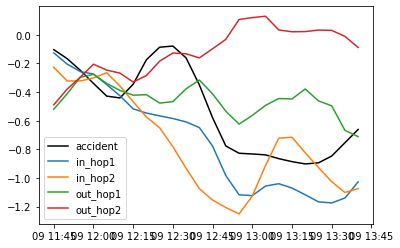

2445 0


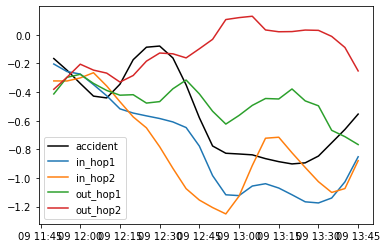

2446 0


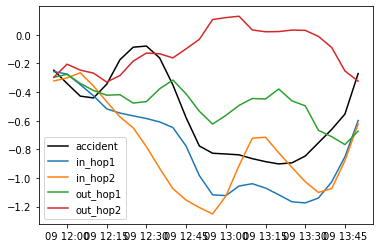

2447 0


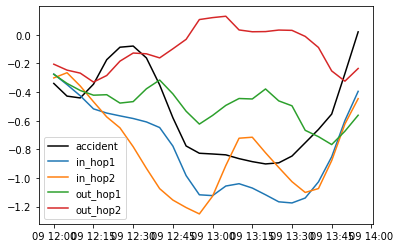

2448 0


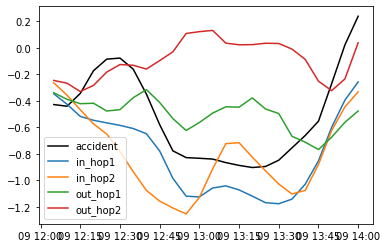

2449 0


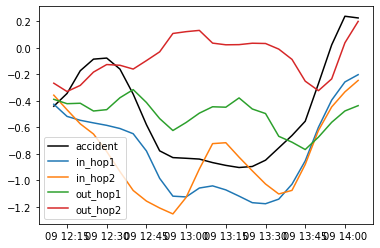

2450 0


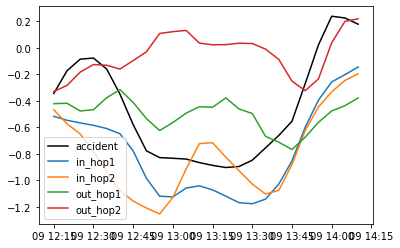

2451 0


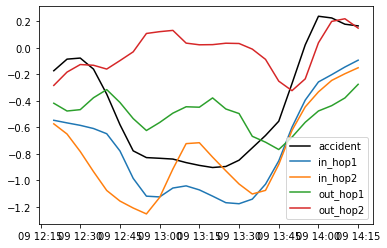

2452 0


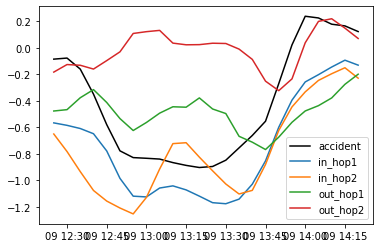

2453 0


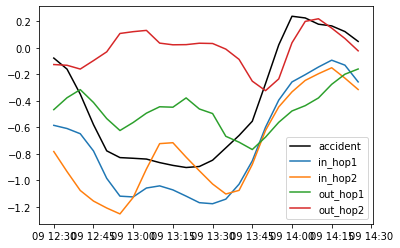

2454 0


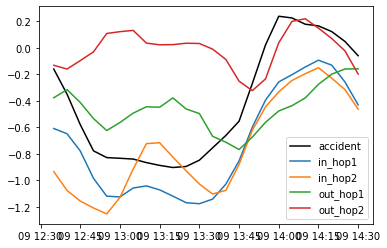

2455 0


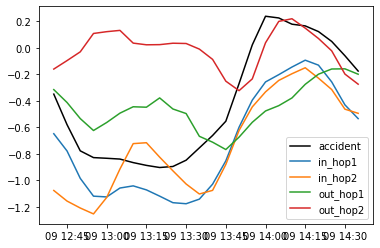

2456 0


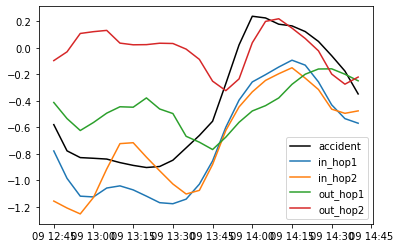

2457 0


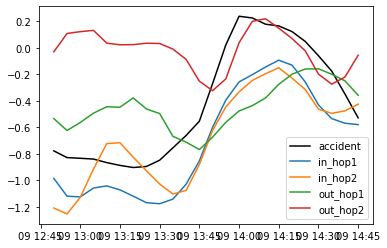

2458 0


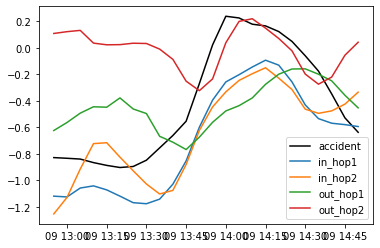

2459 0


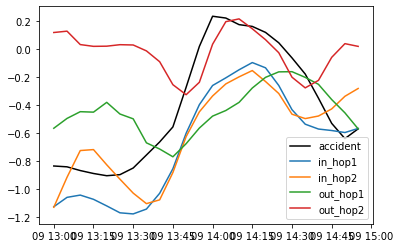

2460 0


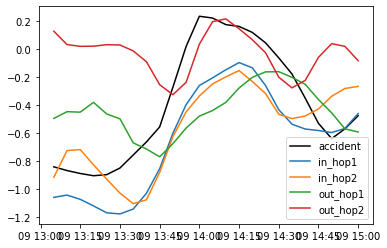

2461 0


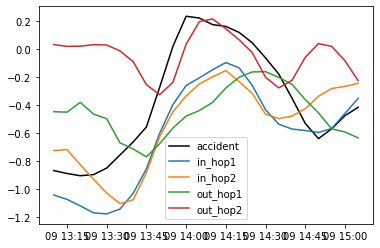

2462 0


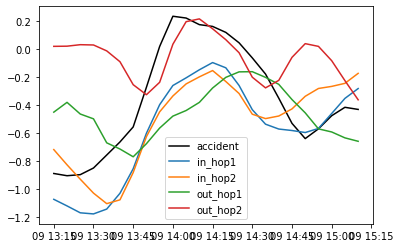

2463 0


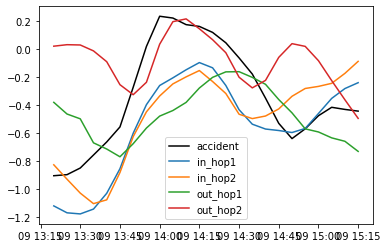

2464 0


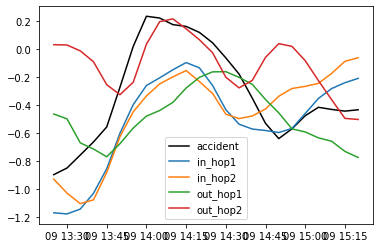

2465 0


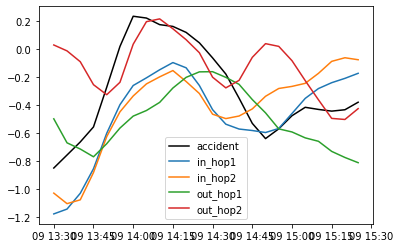

2466 0


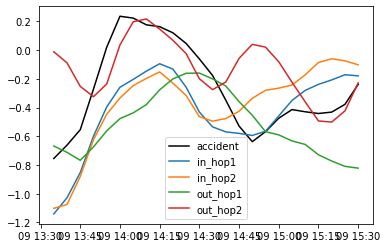

2467 0


In [76]:
cnt = 0
for i in range(1100, len(train_df)):
    
    if test_label.iloc[i, 0] == 0:
        continue
    else:
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
        print(i, pred[i])
        cnt += 1
    if cnt > 30 :
        break
    

### embedding distribution plot

/tmp/ipykernel_4178653/3153301662.py:18: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


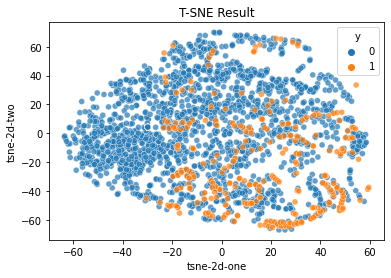

/tmp/ipykernel_4178653/3153301662.py:40: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


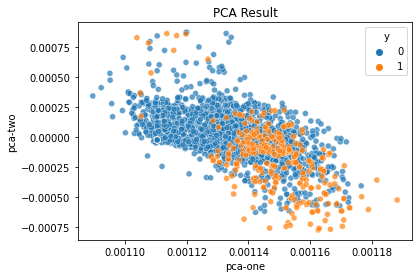

In [71]:
import seaborn as sns 

rndperm = np.random.permutation(2000)


normal = np.where(label_all == 0)
abnormal = np.where(label_all == 1)

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_all = tsne.fit_transform(np.concatenate(out_all))

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = label_all

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(np.concatenate(out_all))

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = label_all

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('PCA Result')
plt.show()

In [ ]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# tsne_all = tsne.fit_transform(np.concatenate(out_all))

# normal = np.where(label_all == 0)
# abnormal = np.where(label_all == 1)

# normal_tsne = tsne_all[normal[0]]
# abnormal_tsne = tsne_all[abnormal[0]]
# # for i in range(len(normal_tsne)):
# for i in range(1000):
#     plt.scatter(normal_tsne[i, 0], normal_tsne[i,1], color='tab:green', s=15)
# for i in range(len(abnormal_tsne)):
#     plt.scatter(abnormal_tsne[i, 0], abnormal_tsne[i,1], color='tab:red', s=7)

# # plt.xlim(-0.005, 0.005)
# # plt.ylim(-0.005, 0.005)
# plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_all = pca.fit_transform(np.concatenate(out_all))

# normal = np.where(label_all == 0)
# abnormal = np.where(label_all == 1)

# normal_pca = pca_all[normal[0]]
# abnormal_pca = pca_all[abnormal[0]]
# # for i in range(len(normal_pca)):
# for i in range(1000):
#     plt.scatter(normal_pca[i, 0], normal_pca[i,1], color='tab:green', s=15)
# for i in range(len(abnormal_pca)):
#     plt.scatter(abnormal_pca[i, 0], abnormal_pca[i,1], color='tab:red', s=7)

# plt.show()

In [36]:
normal = np.where(label_all == 0)
abnormal = np.where(label_all == 1)

Text(0, 0.5, 'Distance')

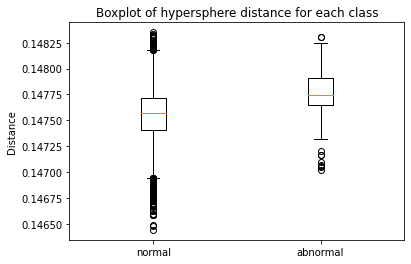

In [45]:
plt.boxplot([dist_all[normal[0]]*1000, dist_all[abnormal[0]]*1000])
# plt.ylim(0.5, 1.25)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

In [38]:
dist_all[normal[0]].mean() <  dist_all[abnormal[0]].mean()

True

## 1902 + 5301

In [36]:
out_sumpool_5301 = pd.read_csv('result/OCGNN_sumpool_acc5301.csv', index_col=0)
out_sumpool_1902 = pd.read_csv('result/OCGNN_sumpool_acc1902.csv', index_col=0)

In [37]:
out_sumpool_5301['pooling'] = 'sum'
out_sumpool_1902['pooling'] = 'sum'

In [41]:
out_sumpool = out_sumpool_5301.copy()
out_sumpool.iloc[:, 4:-1] = (out_sumpool_5301.iloc[:, 4:-1] + out_sumpool_1902.iloc[:, 4:-1])/2
out_sumpool

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP,pooling
0,GCN_gc,standard,0.05,False,0.937037,0.498027,0.987178,0.012822,0.046822,0.493745,0.013495,sum
1,GCN_gc,standard,0.05,True,0.943852,0.749310,0.867412,0.132588,0.549389,0.591962,0.078745,sum
2,GCN_traffic,standard,0.05,False,0.949896,0.490901,0.993196,0.006804,0.019129,0.492162,0.013424,sum
3,GCN_traffic,standard,0.05,True,0.952946,0.612892,0.919920,0.080080,0.263111,0.549208,0.042544,sum
4,GraphSAGE_gc,standard,0.05,False,0.953603,0.491720,0.992717,0.007283,0.017001,0.493152,0.013426,sum
5,GraphSAGE_gc,standard,0.05,True,0.956615,0.602502,0.906423,0.093577,0.238565,0.555500,0.032447,sum
6,GCN_gc,standard,0.10,False,0.845304,0.479142,0.990473,0.009527,0.102704,0.466461,0.013146,sum
7,GCN_gc,standard,0.10,True,0.853723,0.787214,0.930209,0.069791,0.718849,0.523047,0.054706,sum
8,GCN_traffic,standard,0.10,False,0.903808,0.491957,0.989213,0.010787,0.068628,0.484028,0.013399,sum
9,GCN_traffic,standard,0.10,True,0.912728,0.826038,0.894636,0.105364,0.736790,0.569068,0.082211,sum
